# Lesson: Manual ETL

## Introduction

We've heard ETL before.

- **Extract**: Gather data.
- **Transform**: Clean, enrich, aggregate, validate, standardize, and/or anonymize data.
- **Load:** Store the data in intermediate storage, a database, or a data warehouse.

There are some amazing ETL tools, but we're going to go the hard way with manual ETL. (It's brief.)

ETL is incredibly diverse. We can:

- Run ETL in real-time (streaming).
- Analyze risk.
- Make predictions.
- Experiment with statistical data sets.
- Confirm compliance (HIPAA, FERPA, PCI).
- Track media (audio, images, video).
- Chain ETL into ETL into ETL...
- Generate visualizations and reports.

### Learning Outcomes

When you've finished this lesson and its exercises, you should be able to:

- Use extractor classes.
- Use transformation classes.
- Use loader classes.
- Use ETL coordination classes.

## Set Up

We're using a movie review schema and a secondary data set from [movie_reviews.csv](movie_reviews.csv).

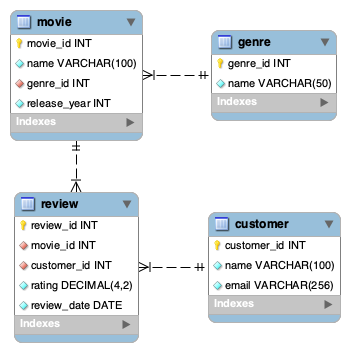

If you haven't already, use MySQL Workbench to open `week-04/lessons/manual-etl/movie-reviews.sql` and execute the schema and data.

Set your [.env](.env) variables to your local database credentials.

## Extract

We can extract from a diverse set of data sources:

- Relational databases (MySQL, PostgreSQL, Oracle, MS SQL Server)

- Non-relational databases (MongoDB, Cassandra, Neo4j, CouchBase)

- File sources (CSV, JSON, XML, unstructured text)

- APIs (public, vendor, client)

- Data warehouses/data lakes (Hadoop, Snowflake, AWS Redshift, Google BigQuery, Azure)

- Real-time streaming (Kafka, AWS SNS/SQS, Google Dataflow)

### SQLAlchemy Models

In [46]:
from datetime import date

from sqlalchemy import Date, Float, ForeignKey, Integer, String
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column, relationship


class Base(DeclarativeBase):
    pass


class Genre(Base):
    __tablename__ = "genre"

    genre_id: Mapped[int] = mapped_column(Integer, primary_key=True, autoincrement=True)
    name: Mapped[str] = mapped_column(String(50), nullable=False, unique=True)

    def __repr__(self):
        return f"<Genre(genre_id={self.genre_id}, name={self.name})>"


class Movie(Base):
    __tablename__ = "movie"

    movie_id: Mapped[int] = mapped_column(Integer, primary_key=True, autoincrement=True)
    name: Mapped[str] = mapped_column(String(100), nullable=False)
    genre_id: Mapped[int] = mapped_column(
        Integer, ForeignKey("genre.genre_id"), nullable=False
    )
    release_year: Mapped[int] = mapped_column(Integer, nullable=False)

    genre: Mapped[Genre] = relationship(Genre)

    def __repr__(self):
        return f"<Movie(movie_id={self.movie_id}, name={self.name}, genre_id={self.genre_id}, release_year={self.release_year})>"


class Customer(Base):
    __tablename__ = "customer"

    customer_id: Mapped[int] = mapped_column(
        Integer, primary_key=True, autoincrement=True
    )
    name: Mapped[str] = mapped_column(String(100), nullable=False)
    email: Mapped[str] = mapped_column(String(256), nullable=False, unique=True)

    def __repr__(self):
        return f"<Customer(customer_id={self.customer_id}, name={self.name}, email={self.email})>"


class Review(Base):
    __tablename__ = "review"

    review_id: Mapped[int] = mapped_column(
        Integer, primary_key=True, autoincrement=True
    )
    movie_id: Mapped[int] = mapped_column(
        Integer, ForeignKey("movie.movie_id"), nullable=False
    )
    customer_id: Mapped[int] = mapped_column(
        Integer, ForeignKey("customer.customer_id"), nullable=False
    )
    rating: Mapped[float] = mapped_column(Float, nullable=False)
    review_date: Mapped[date] = mapped_column(Date, nullable=False)

    movie: Mapped[Movie] = relationship(Movie)
    customer: Mapped[Customer] = relationship(Customer)

    def __repr__(self):
        return f"<Review(review_id={self.review_id}, movie_id={self.movie_id}, customer_id={self.customer_id}, rating={self.rating}, review_date={self.review_date})>"

    def __str__(self):
        return f"Review ID: {self.review_id}, Movie: {self.movie.name}, Customer ID: {self.customer_id}, Rating: {self.rating}, Review Date: {self.review_date}"


### MovieReview Data Class

In [47]:
from dataclasses import dataclass


@dataclass
class MovieReview:
    anonymous_id: int
    movie_id: int
    movie_name: str
    rating: float
    review_date: date

    def to_tuple(self):
        return (
            self.anonymous_id,
            self.movie_id,
            self.movie_name,
            self.rating,
            self.review_date,
        )


### Data Sources

Here are our extraction classes. 

In our `ReviewRepository`, we extract data from a MySQL database. We extract every `review` record, though that's not particularly common. If we have giant data sets (millions or billions of records), we need to filter things in chunks. 

Data can be time sensitive. When we're generating data on a current day, we look back to extract the previous day's data. Time-sensitive chunks can also be in minutes, hours, days, weeks, months, quarters, and years.

As a company, our data can be customer/company sensitive as well. Say that we're part of a hospital corporation. Our ETL process can focus on a particular health insurance company.

In our `DictReviewRepository`, we extract reviews from a CSV file. We don't want or need to validate this data. That's part of the transform step. File sources (or APIs, data warehouses, etc) can be filtered as well.

#### Sample Data

```csv
anonymous_id,movie_name,genre,rating,review_date
19,Wicked,Musical,8.89,2024-09-19
11,Wicked,Musical,1.11,2024-02-09
3,,Musical,4.37,2024-10-14
6,Wicked,Musical,8.94,2024-02-23
```

In [48]:
import csv

from sqlalchemy import select
from sqlalchemy.orm import Session


class ReviewRepository:
    def __init__(self, session: Session):
        self._session = session

    def find_all(self):
        stmt = select(Review)
        return list(self._session.scalars(stmt))

    def is_connected(self):
        return self._session.bind is not None

    def close(self):
        if self.is_connected():
            self._session.close()


class DictReviewRepository:
    def __init__(self, file_path: str):
        self.file_path = file_path

    def find_all(self):
        records = []

        with open(self.file_path, "r") as file:
            reader = csv.DictReader(file)
            for record in reader:
                records.append(record)

        return records

#### Run the code

In [ ]:
from dynaconf import Dynaconf
from sqlalchemy import create_engine


def build_engine():
    settings = Dynaconf(envvar_prefix="DB", load_dotenv=True)
    return create_engine(settings.ENGINE_URL, echo=False)


engine = build_engine()
session = Session(engine)

dbRepository = ReviewRepository(session)
csvRepository = DictReviewRepository("movie_reviews.csv")

print("Database Reviews:")
db_reviews = dbRepository.find_all()
for review in db_reviews[:10]:
    print(review)

print("CSV Reviews:")
csv_reviews = csvRepository.find_all()
for review in csv_reviews[:10]:
    print(review)

## Transform

Transformation is incredibly diverse. We can:

- **Clean data**: remove invalid records, remove duplicates
- **Convert data**: convert from one data type to another, make strings with `$` and `%` a valid number
- **Validate data**: apply business or domain rules
- **Enrich data**: merge two data sets to create more complex and interesting data
- **Anonymize data**: erase private information

    (Latanya Sweeney published a paper: [Only You, Your Doctor, and Many Others May Know](https://techscience.org/a/2015092903/).)

- **Aggregate data**: generate insights, prepare for data at scale
- **Standardize data**: adhere to a format that may be universally accepted

### Transformation Classes

Depending on our scenario, we may have multiple transformer classes. This `Transformer` is _relatively_ simple, but transformations can be a complex and torturous process.

In [50]:
import re


class Transformer:
    def transform(self, db_reviews, csv_reviews):
        print(f"DB review count: {len(db_reviews)}")
        movie_reviews = self.db_to_movie_reviews(db_reviews)
        print(f"Movie review count: {len(movie_reviews)}")

        print(f"CSV review count: {len(csv_reviews)}")
        csv_reviews = self.remove_na_anonymous_id(csv_reviews)
        print(f"Remove anonymous_id CSV review count: {len(csv_reviews)}")
        csv_reviews = self.remove_na_movie_name(csv_reviews)
        print(f"Remove movie name CSV review count: {len(csv_reviews)}")

        # we don't care about genre or review date

        csv_reviews = self.convert_percent_to_number(csv_reviews)
        print(f"% to number CSV review count: {len(csv_reviews)}")
        movie_reviews = self.merge(movie_reviews, csv_reviews)
        print(f"Merged movie review count: {len(movie_reviews)}")

        movie_reviews = self.remove_dupes(movie_reviews)
        print(f"Remove duplicates review count: {len(movie_reviews)}")
        movie_reviews = self.remove_unmatched_ratings(movie_reviews)
        print(f"Remove unmatched ratings review count: {len(movie_reviews)}")

        return movie_reviews

    def db_to_movie_reviews(self, db_reviews):
        return [
            MovieReview(
                anonymous_id=review.customer_id,
                movie_id=review.movie_id,
                movie_name=review.movie.name,
                rating=review.rating,
                review_date=review.review_date,
            )
            for review in db_reviews
        ]

    def remove_na_anonymous_id(self, csv_reviews):
        return [review for review in csv_reviews if review["anonymous_id"].isnumeric()]

    def remove_na_movie_name(self, csv_reviews):
        return [
            review for review in csv_reviews if len(review["movie_name"].strip()) > 0
        ]

    def convert_percent_to_number(self, csv_reviews):
        results = []
        for review in csv_reviews:
            if isinstance(review["rating"], float):
                pass
            elif "%" in review["rating"]:
                review["rating"] = float(review["rating"].replace("%", "")) / 10
            elif re.match(r"\d+.?\d*", review["rating"]):
                review["rating"] = float(review["rating"])
            else:
                continue
            results.append(review)

        return results

    def merge(self, movie_reviews, csv_reviews):
        movie_set = set([(r.movie_id, r.movie_name) for r in movie_reviews])
        movie_dict = {movie_tuple[1]: movie_tuple[0] for movie_tuple in movie_set}

        for review in csv_reviews:
            movie_reviews.append(
                MovieReview(
                    anonymous_id=int(review["anonymous_id"]),
                    movie_id=movie_dict.get(review["movie_name"], 0),
                    movie_name=review["movie_name"],
                    rating=review["rating"],
                    review_date=date.fromisoformat(review["review_date"])
                    if len(review["review_date"].strip()) > 0
                    else None,
                )
            )

        return movie_reviews

    def remove_dupes(self, movie_reviews):
        results = []

        seen = set()
        for review in movie_reviews:
            key = (review.anonymous_id, review.movie_name, round(review.rating, 2))
            if key in seen:
                continue
            seen.add(key)
            results.append(review)

        return results

    def remove_unmatched_ratings(self, movie_reviews):
        results = []
        rating_map = {}
        for review in movie_reviews:
            key = (review.anonymous_id, review.movie_name)
            if key in rating_map:
                rating_map[key].append(review)
            else:
                rating_map[key] = [review]

        for _, v in rating_map.items():
            if len(v) == 1:
                results.append(v[0])

        return results

#### Run the code

In [ ]:
transformer = Transformer()
results = transformer.transform(db_reviews, csv_reviews)

print("Transformed Reviews:")
for review in results[:10]:
    print(review)

### Explanation

1. In our SQLAlchemy models, we "flatten" our object graph (`Customer` &lt;- `Review` -&gt; `Movie` -&gt; `Genre`) into a `MovieReview` record.

    ```py
    def db_to_movie_reviews(self, db_reviews):
        return [
            MovieReview(
                anonymous_id=review.customer_id,
                movie_id=review.movie_id,
                movie_name=review.movie.name,
                rating=review.rating,
                review_date=review.review_date,
            )
            for review in db_reviews
        ]
    ```

    Our database is pretty reliable, so we're confident.

2. In our CSV records, we ignore invalid ids. The requirement is that it's an integer.

    ```py
    def remove_na_anonymous_id(self, csv_reviews):
        return [review for review in csv_reviews if review["anonymous_id"].isnumeric()]
    ```

    This CSV file contains third-party data. It's not particularly reliable. We don't have customer names. We don't have a movie identifier. Some "anonymous" identifiers may come from other sources.

3. Remove invalid movie titles. The requirement is that it's a string length greater than 0.

    ```py
    def remove_na_movie_name(self, csv_reviews):
        return [
            review for review in csv_reviews if len(review["movie_name"].strip()) > 0
        ]
    ```

4. Convert a string rating to a float. It's sort of goofy, but formats can include: `"42%"` and `"4.47"`.

    ```py
     def convert_percent_to_number(self, csv_reviews):
        results = []
        for review in csv_reviews:
            if isinstance(review["rating"], float):
                pass
            elif "%" in review["rating"]:
                review["rating"] = float(review["rating"].replace("%", "")) / 10
            elif re.match(r"\d+.?\d*", review["rating"]):
                review["rating"] = float(review["rating"])
            else:
                continue
            results.append(review)

        return results
    ```

5. Next we merge our CSV records into a `MovieReview` and include it with the mapped database records.

    ```py
    def merge(self, movie_reviews, csv_reviews):
        movie_set = set([(r.movie_id, r.movie_name) for r in movie_reviews])
        movie_dict = {movie_tuple[1]: movie_tuple[0] for movie_tuple in movie_set}

        for review in csv_reviews:
            movie_reviews.append(
                MovieReview(
                    anonymous_id=int(review["anonymous_id"]),
                    movie_id=movie_dict.get(review["movie_name"], 0),
                    movie_name=review["movie_name"],
                    rating=review["rating"],
                    review_date=date.fromisoformat(review["review_date"])
                    if len(review["review_date"].strip()) > 0
                    else None,
                )
            )

        return movie_reviews
    ```

6. We remove duplicates matching the customer/anonymous id, movie name, and rating rounded to two decimals.

    ```py
    def remove_dupes(self, movie_reviews):
        results = []

        seen = set()
        for review in movie_reviews:
            key = (review.anonymous_id, review.movie_name, round(review.rating, 2))
            if key in seen:
                continue
            seen.add(key)
            results.append(review)

        return results
    ```

7. Then we remove unmatched ratings. How do we decide which rating is correct? We just ignore them all.

    ```py
    def remove_unmatched_ratings(self, movie_reviews):
        results = []
        rating_map = {}
        for review in movie_reviews:
            key = (review.anonymous_id, review.movie_name)
            if key in rating_map:
                rating_map[key].append(review)
            else:
                rating_map[key] = [review]

        for value in rating_map.values():
            if len(value) == 1:
                results.append(value[0])

        return results
    ```

## Load

The load step can take many forms and is decided by the data pipeline's purpose. There are many formats.

- **Denormalized data**: used in analysis or chaining ETL pipelines.

- **Aggregated data**: used in analysis.

- **Normalized data**: confirm a single source of truth, chaining ETL pipelines.

- **Raw data**: confirm compliance, chaining ETL pipelines, often used in data lakes.

---

And loading can go into many data sources.

- Relational databases (MySQL, PostgreSQL, Oracle, MS SQL Server)

- Non-relational databases (MongoDB, Cassandra, Neo4j, CouchBase)

- File sources (CSV, JSON, XML, unstructured text)

- APIs (public, vendor, client)

- Data warehouses/data lakes (Hadoop, Snowflake, AWS Redshift, Google BigQuery, Azure)

- Real-time streaming (Kafka, AWS SNS/SQS, Google Dataflow)

### Loader

We keep our `MovieReviewCsvWriter` pretty basic, loading to a CSV file.

In [52]:
class MovieReviewCsvWriter:
    def __init__(self, file_path: str):
        self.file_path = file_path

    def add_all(self, movie_reviews):
        with open(self.file_path, "w") as file:
            writer = csv.writer(file)
            writer.writerow(
                ["anonymous_id", "movie_id", "movie_name", "rating", "review_date"]
            )
            writer.writerows(mr.to_tuple() for mr in movie_reviews)

#### Run the code

In [53]:
writer = MovieReviewCsvWriter("movie_reviews_transformed.csv")
writer.add_all(results)

## Dependency Injection

We'll add an additional class that coordinates all of the ETL process. Our extractor classes, transformer classes, and loader classes all get _injected_ into into the ETL class. Our ETL class _depends on_ those classes.

### Loose Coupling

**Loose coupling** is a flexible dependency that can be swapped in and out. It's dependency injection. As long as the method signature is the same, we can extract data from any data source, transform data from any transformation, and load data from any data source.

```py
class A:
    def msg(self):
        print("I'm an A class.")


class B:
    def msg(self):
        print("I'm an B class.")


class C:
    def msg(self):
        print("I'm an C class.")


class Parent:
    def __init__(self, dependency):
        self._dependency = dependency

    def msg(self):
        self._dependency.msg()


parent = Parent(A())
parent.msg()

parent = Parent(B())
parent.msg()

parent = Parent(C())
parent.msg()

# I'm an A class.
# I'm an B class.
# I'm an C class.
```

(This will be relevant in testing.)

### Tight Coupling

**Tight coupling** doesn't allow us any flexibility.

```py
class A:
    def msg(self):
        print("I'm an A class.")


class Parent:
    def __init__(self):
        self._dependency = A()

    def msg(self):
        self._dependency.msg()

parent = Parent()
parent.msg()
# I'm an A class.
```

### ETL Coordination

In [54]:
class ETLProcessor:
    def __init__(
        self,
        dbRepository,
        csvRepository,
        movieReviewWriter,
        transformer: Transformer,
    ):
        self._dbRepository = dbRepository
        self._csvRepository = csvRepository
        self._movieReviewWriter = movieReviewWriter
        self._transformer = transformer

    def extract(self):
        db_reviews = self._dbRepository.find_all()
        csv_reviews = self._csvRepository.find_all()
        return db_reviews, csv_reviews

    def load(self, data):
        self._movieReviewWriter.add_all(data)

    def process(self):
        db_reviews, csv_reviews = self.extract()
        transformed_data = self._transformer.transform(db_reviews, csv_reviews)
        self.load(transformed_data)

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self._dbRepository.close()

#### Run the code

In [ ]:
dbRepository = ReviewRepository(Session(engine))
csvRepository = DictReviewRepository("movie_reviews.csv")
movieReviewWriter = MovieReviewCsvWriter("movie_reviews_transformed.csv")
transformer = Transformer()

with ETLProcessor(
    dbRepository,
    csvRepository,
    movieReviewWriter,
    transformer,
) as etl:
    etl.process()

Finally, shut down our engine.

In [56]:
engine.dispose()